# Controlnet Openpose

画像から人物の姿勢を抽出して，ControlNetを使い同じ姿勢の異なる画像を生成する方法です．
- ドキュメント:https://huggingface.co/lllyasviel/control_v11p_sd15_openpose

<a href="https://colab.research.google.com/github/fuyu-quant/data-science-wiki/blob/main/multimodal/text_guided_image_to_image/contrlonet_openpose.ipynb" target="_blank" rel="noopener noreferrer"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install diffusers==0.23.0
!pip install accelerate==0.24.1
!pip install transformers==4.35.0
!pip install opencv-contrib-python==4.8.0.76
!pip3 install -U xformers --index-url https://download.pytorch.org/whl/cu118
!pip install controlnet_aux==0.0.3
#!pip install torch==2.1.0+cu118

In [2]:
import torch
print(torch.version.cuda)
# 実行が確認できたcudaのバージョン
# 11.8

11.8


In [1]:
import torch
import os
import requests
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
import numpy as np
from controlnet_aux import OpenposeDetector

from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

### 画像の用意

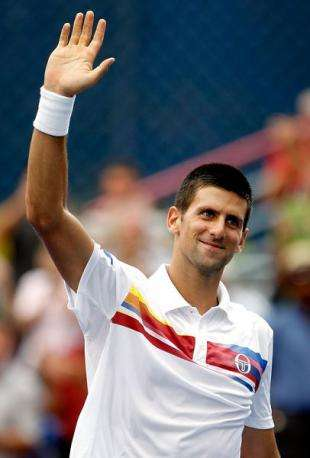

In [2]:
image = load_image("https://huggingface.co/lllyasviel/control_v11p_sd15_openpose/resolve/main/images/input.png")
image

### 姿勢の抽出

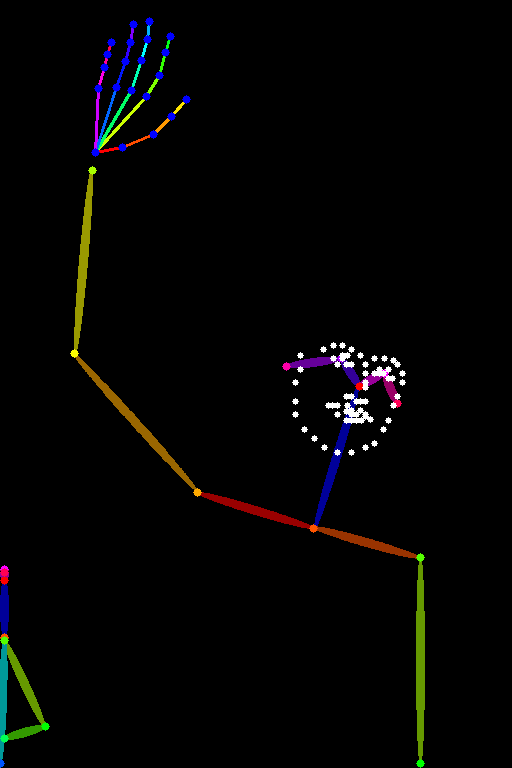

In [3]:
processor = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

control_image = processor(image, hand_and_face=True)
control_image.save("control.png")
control_image

### Stable Diffusionのダウンロード

In [10]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [11]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(0)

### 姿勢を維持した画像生成

In [12]:
prompt = "space suit, 8k"
image = pipe(prompt, num_inference_steps=30, generator=generator, image=control_image).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

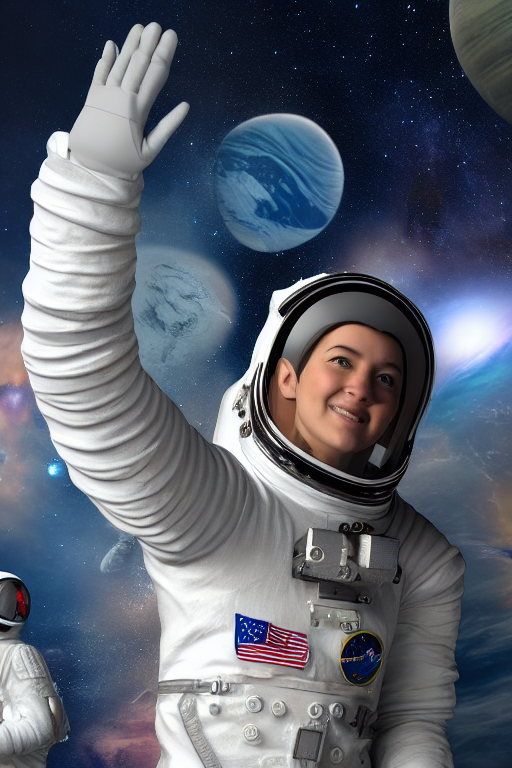

In [13]:
image

In [15]:
image.save('image_out.png')